# CBN class and script

In [57]:
# import libraries


# Classes

In [58]:
class LocalScene:
    def __init__(self, l_values=None):
        self.l_values = l_values
        # Calculated properties
        self.l_attractors = []


class LocalAttractor:
    def __init__(self, l_states):
        self.l_states = l_states


class LocalState:
    def __init__(self, l_variable_values):
        self.l_variable_values = l_variable_values

In [59]:
from satispy import Variable  # Library to resolve SAT
from satispy.solver import Minisat  # Library to resolve SAT

class LocalNetwork:
    def __init__(self, num_local_network, l_var_intern, des_funct_variables=None):
        if des_funct_variables is None:
            des_funct_variables = []
        self.index = num_local_network
        self.l_var_intern = l_var_intern
        self.des_funct_variables = des_funct_variables

        # Processed properties
        # self.l_input_signals = []
        # self.l_output_signals = []
        self.l_var_exterm = []
        self.l_var_total = []
        self.num_var_total = 0
        self.dic_var_cnf = {}

        # Calculated properties
        self.l_local_scenes = []
        # self.l_local_attractors = []

    def show(self):
        print('Local Network', self.index)
        print('Variables intern : ', self.l_var_intern)
        # Description variables
        for o_variable in self.des_funct_variables:
            o_variable.show()

        # print('Input Signals:')
        # for o_signal in self.l_input_signals:
        #     o_signal.show()
        # print('Output Signals:')
        # for o_signal in self.l_output_signals:
        #     o_signal.show()

    def process_input_signals(self, l_input_signals):
        # Processing the input signals of local network
        for o_signal in l_input_signals:
            self.l_var_exterm.append(o_signal.index_variable_signal)
        # update the value of list_variables
        self.l_var_total.extend(self.l_var_intern.copy())
        self.l_var_total.extend(self.l_var_exterm.copy())
        self.num_var_total = len(self.l_var_total)

    @staticmethod
    def find_local_attractors(o_local_network, l_local_scenes=None):
        if l_local_scenes is None:
            o_local_scene = LocalScene()
            o_local_scene.l_attractors = LocalNetwork.find_local_scenary_attractors(o_local_network)
            o_local_network.l_local_scenes.append(o_local_scene)
        for scenery in l_local_scenes:
            o_local_scene = LocalScene(scenery)
            o_local_scene.l_attractors = LocalNetwork.find_local_scenary_attractors(o_local_network, ''.join(scenery))
            o_local_network.l_local_scenes.append(o_local_scene)
        return o_local_network

    @staticmethod
    def gen_boolean_formulation_satispy(o_local_network, number_of_transitions, l_attractors_clauses,
                                        l_signal_coupling):
        # create dictionary of cnf variables!!
        for variable in o_local_network.l_var_total:
            for transition_c in range(0, number_of_transitions):
                o_local_network.dic_var_cnf[str(variable) + "_" + str(transition_c)] = Variable(
                    str(variable) + "_" + str(transition_c))

        cont_transition = 0
        boolean_function = Variable("0_0")
        for transition in range(1, number_of_transitions):
            cont_clause_global = 0
            boolean_expression_equivalence = Variable("0_0")
            for o_variable_model in o_local_network.des_funct_variables:
                cont_clause = 0
                boolean_expression_clause_global = Variable("0_0")
                for clause in o_variable_model.cnf_function:
                    boolean_expression_clause = Variable("0_0")
                    cont_term = 0
                    for term in clause:
                        term_aux = abs(int(term))
                        if cont_term == 0:
                            if str(term)[0] != "-":
                                boolean_expression_clause = o_local_network.dic_var_cnf[
                                    str(term_aux) + "_" + str(transition - 1)]
                            else:
                                boolean_expression_clause = -o_local_network.dic_var_cnf[
                                    str(term_aux) + "_" + str(transition - 1)]
                        else:
                            if str(term)[0] != "-":
                                boolean_expression_clause = o_local_network.dic_var_cnf[str(term_aux) + "_" + str(
                                    transition - 1)] | boolean_expression_clause
                            else:
                                boolean_expression_clause = -o_local_network.dic_var_cnf[
                                    str(term_aux) + "_" + str(transition - 1)] | boolean_expression_clause
                        cont_term = cont_term + 1
                    if cont_clause == 0:
                        boolean_expression_clause_global = boolean_expression_clause
                    else:
                        boolean_expression_clause_global = boolean_expression_clause_global & boolean_expression_clause
                    cont_clause = cont_clause + 1
                if cont_clause_global == 0:
                    boolean_expression_equivalence = o_local_network.dic_var_cnf[
                                                         str(o_variable_model.variable_name) + "_" + str(
                                                             transition)] >> boolean_expression_clause_global
                    boolean_expression_equivalence = boolean_expression_equivalence & (
                            boolean_expression_clause_global >> o_local_network.dic_var_cnf[
                        str(o_variable_model.variable_name) + "_" + str(transition)])
                else:
                    boolean_expression_equivalence = boolean_expression_equivalence & (o_local_network.dic_var_cnf[
                                                                                           str(o_variable_model.variable_name) + "_" + str(
                                                                                               transition)] >> boolean_expression_clause_global)
                    boolean_expression_equivalence = boolean_expression_equivalence & (
                            boolean_expression_clause_global >> o_local_network.dic_var_cnf[
                        str(o_variable_model.variable_name) + "_" + str(transition)])
                if not o_variable_model.cnf_function:
                    print("ENTRO CASO ATIPICO")
                    boolean_function = boolean_function & (
                            o_local_network.dic_var_cnf[str(o_variable_model.variable_name) + "_" + str(transition)] | -
                    o_local_network.dic_var_cnf[str(o_variable_model.variable_name) + "_" + str(transition)])
                cont_clause_global = cont_clause_global + 1
            if cont_transition == 0:
                boolean_function = boolean_expression_equivalence
            else:
                boolean_function = boolean_function & boolean_expression_equivalence
            # validate blank gens
            cont_transition = cont_transition + 1

        # ASSIGN VALUES FOR PERMUTATIONS
        cont_permutation = 0
        for element in o_local_network.l_var_exterm:
            # print oRDD.list_of_v_exterm
            for v_transition in range(0, number_of_transitions):
                # print l_signal_coupling[cont_permutation]
                if l_signal_coupling[cont_permutation] == "0":
                    boolean_function = boolean_function & -o_local_network.dic_var_cnf[
                        str(element) + "_" + str(v_transition)]
                    # print (str(element) +"_"+ str(v_transition))
                else:
                    boolean_function = boolean_function & o_local_network.dic_var_cnf[
                        str(element) + "_" + str(v_transition)]
                    # print (str(element) +"_"+ str(v_transition))
            cont_permutation = cont_permutation + 1

        # add attractors to boolean function
        if len(l_attractors_clauses) > 0:
            boolean_function_of_attractors = Variable("0_0")
            cont_clause = 0
            for clause in l_attractors_clauses:
                bool_expr_clause_attractors = Variable("0_0")
                cont_term = 0
                for term in clause:
                    term_aux = abs(int(term))
                    if cont_term == 0:
                        if term[0] != "-":
                            bool_expr_clause_attractors = o_local_network.dic_var_cnf[
                                str(term_aux) + "_" + str(number_of_transitions - 1)]
                        else:
                            bool_expr_clause_attractors = -o_local_network.dic_var_cnf[
                                str(term_aux) + "_" + str(number_of_transitions - 1)]
                    else:
                        if term[0] != "-":
                            bool_expr_clause_attractors = bool_expr_clause_attractors & \
                                                          o_local_network.dic_var_cnf[
                                                              str(term_aux) + "_" + str(
                                                                  number_of_transitions - 1)]
                        else:
                            bool_expr_clause_attractors = bool_expr_clause_attractors & - \
                                o_local_network.dic_var_cnf[str(term_aux) + "_" + str(number_of_transitions - 1)]
                    cont_term = cont_term + 1
                if cont_clause == 0:
                    boolean_function_of_attractors = -bool_expr_clause_attractors
                else:
                    boolean_function_of_attractors = boolean_function_of_attractors & - bool_expr_clause_attractors
                cont_clause = cont_clause + 1
            boolean_function = boolean_function & boolean_function_of_attractors

        # Add all the variables of the position 0 to the boolean function
        for variable in o_local_network.l_var_total:
            boolean_function = boolean_function & (
                    o_local_network.dic_var_cnf[str(variable) + "_0"] | - o_local_network.dic_var_cnf[
                str(variable) + "_0"])
        # print(boolean_function)
        return boolean_function

    @staticmethod
    def find_local_scenary_attractors(o_local_network, scene=None):
        # MEJORAR EL METODO PARA QUE ADMITA UN OBJETO ATRACTOR
        def count_state_repeat(v_estate, path_candidate):
            # input type [[],[],...[]]
            number_of_times = 0
            for v_element in path_candidate:
                if v_element == v_estate:
                    number_of_times = number_of_times + 1
            return number_of_times

        print("BEGIN TO FIND ATTRACTORS")
        print("NETWORK NUMBER : " + str(o_local_network.index) + " PERMUTATION SIGNAL COUPLING: " + scene)
        # create boolean expression initial with "n" transitions
        set_of_attractors = []
        v_num_transitions = 3
        l_attractors = []
        l_attractors_clauses = []

        # REPEAT CODE
        v_bool_function = o_local_network.gen_boolean_formulation_satispy(o_local_network, v_num_transitions,
                                                                          l_attractors_clauses, scene)
        m_response_sat = []
        o_solver = Minisat()
        o_solution = o_solver.solve(v_bool_function)

        # print(o_local_network.number_of_v_total)
        if o_solution.success:
            for j in range(0, v_num_transitions):
                m_response_sat.append([])
                for i in o_local_network.l_var_total:
                    # print("_________________________________________")
                    # print("Variable de Error:", f"{i}_{j}")
                    # print(v_bool_function)
                    m_response_sat[j].append(o_solution[o_local_network.dic_var_cnf[f'{i}_{j}']])
        else:
            print("The expression cannot be satisfied")

        # BLOCK ATTRACTORS
        m_aux_sat = []
        if len(m_response_sat) != 0:
            # TRANSFORM BOOLEAN TO MATRIZ BOOLEAN RESPONSE
            for j in range(0, v_num_transitions):
                matriz_aux_sat = []
                for i in range(0, o_local_network.num_var_total):
                    if m_response_sat[j][i]:
                        matriz_aux_sat.append("1")
                    else:
                        matriz_aux_sat.append("0")
                m_aux_sat.append(matriz_aux_sat)
            # m_resp_boolean = m_aux_sat
        m_resp_boolean = m_aux_sat
        # BLOCK ATTRACTORS
        # REPEAT CODE

        while len(m_resp_boolean) > 0:
            # print ("path")
            # print (m_resp_boolean)
            # print ("path")
            path_solution = []
            for path_transition in m_resp_boolean:
                path_solution.append(path_transition)

            # new list of state attractors
            l_news_estates_attractor = []
            # check attractors
            for v_state in path_solution:
                v_state_count = count_state_repeat(v_state, path_solution)
                if v_state_count > 1:
                    atractor_begin = path_solution.index(v_state) + 1
                    atractor_end = path_solution[atractor_begin:].index(v_state)
                    l_news_estates_attractor = path_solution[atractor_begin - 1:(atractor_begin + atractor_end)]
                    l_attractors = l_attractors + l_news_estates_attractor
                    # add attractors like list of list
                    set_of_attractors.append(l_news_estates_attractor)
                    break

            # print set_of_attractors
            if len(l_news_estates_attractor) == 0:
                # print ("duplicating")
                v_num_transitions = v_num_transitions * 2

            # TRANSFORM LIST OF ATTRACTORS TO CLAUSES
            for clause_attractor in l_attractors:
                clause_variable = []
                cont_variable = 0
                for estate_attractor in clause_attractor:
                    if estate_attractor == "0":
                        clause_variable.append("-" + str(o_local_network.l_var_total[cont_variable]))
                    else:
                        clause_variable.append(str(o_local_network.l_var_total[cont_variable]))
                    cont_variable = cont_variable + 1
                l_attractors_clauses.append(clause_variable)

            # print l_attractors_clauses
            # REPEAT CODE
            v_bool_function = o_local_network.gen_boolean_formulation_satispy(o_local_network, v_num_transitions,
                                                                              l_attractors_clauses, scene)
            m_response_sat = []
            o_solver = Minisat()
            o_solution = o_solver.solve(v_bool_function)

            if o_solution.success:
                for j in range(0, v_num_transitions):
                    m_response_sat.append([])
                    for i in o_local_network.l_var_total:
                        m_response_sat[j].append(o_solution[o_local_network.dic_var_cnf[f'{i}_{j}']])
            else:
                # print(" ")
                print("The expression cannot be satisfied")

            # BLOCK ATTRACTORS
            m_aux_sat = []
            if len(m_response_sat) != 0:
                # TRANSFORM BOOLEAN TO MATRIZ BOOLEAN RESPONSE
                for j in range(0, v_num_transitions):
                    matriz_aux_sat = []
                    for i in range(0, o_local_network.num_var_total):
                        if m_response_sat[j][i]:
                            matriz_aux_sat.append("1")
                        else:
                            matriz_aux_sat.append("0")
                    m_aux_sat.append(matriz_aux_sat)
                # m_resp_boolean = m_aux_sat
            m_resp_boolean = m_aux_sat
            # BLOCK ATTRACTORS
            # REPEAT CODE

        # Creating the objects of the attractor
        res = []
        for o_attractor in set_of_attractors:
            l_local_states = []
            for o_state in o_attractor:
                o_local_state = LocalState(o_state)
                l_local_states.append(o_local_state)
            o_local_attractor = LocalAttractor(l_local_states)
            res.append(o_local_attractor)

        print("END OF FIND ATTRACTORS")
        return res


In [60]:
# VARIABLE MODEL ONLY HAVE VARIABLE_NAME, CNF FUNCTION
class InternalVariable:
    variable_name = 0
    # list_interacts = []
    cnf_function = []

    def __init__(self, name_variable, cnf_function):
        self.variable_name = int(name_variable)
        self.cnf_function = cnf_function

    def show(self):
        print("V: " + str(self.variable_name) + " CNF :" + str(self.cnf_function))


In [61]:
import re  # analysis of regular expressions
import operator  # unary operator management

from string import ascii_lowercase, ascii_uppercase  # import the list of uppercase and lowercase letters
from itertools import product  # generate combinations of numbers
from collections import namedtuple  # structures like trees


class DirectedEdge:
    def __init__(self, input_local_network, output_local_network, l_output_variables, index_variable_signal,
                 coupling_function):
        self.index_variable_signal = index_variable_signal
        self.input_local_network = input_local_network
        self.output_local_network = output_local_network
        self.l_output_variables = l_output_variables
        self.coupling_function = coupling_function

        # Calculated properties
        self.true_table = self.process_true_table()
        # Defined the kind for every coupling signal: stable 1, not compute 2
        #     1: "restricted",
        #     2: "not compute",
        #     3: "stable",
        #     4: "not stable"
        self.kind_signal = 2

    def show(self):
        print("Input Local Network:", str(self.input_local_network) + "\n"
              + "Network Output:", str(self.output_local_network) + "\n"
              + "Variables:", str(self.l_output_variables) + "\n"
              + "Name Variable:", str(self.index_variable_signal) + "\n"
              + "Coupling Function:", str(self.coupling_function) + "\n"
              + "Truth Table:", str(self.true_table))

    def process_true_table(self):
        r_true_table = {}
        # print("Generating the True Table")
        # First we must understand the coupling signal
        # we will use regular expressions to recognize the boolean formula

        # TOKENIZATION
        # Regular expression matching optional whitespace followed by a token
        # (if group 1 matches) or an error (if group 2 matches).
        TOKEN_RE = re.compile(r'\s*(?:([A-Za-z01()~∧∨→↔])|(\S))')

        # Special token indicating the end of the input string.
        TOKEN_END = '<end of input>'

        def tokenize(s):
            """Generate tokens from the string s, followed by TOKEN_END."""
            for match in TOKEN_RE.finditer(s):
                token, error = match.groups()
                if token:
                    yield token
                else:
                    raise SyntaxError("Unexpected character {!r}".format(error))
            yield TOKEN_END

        # PARSING
        Constant = namedtuple('Constant', 'value')
        Variable = namedtuple('Variable', 'name')
        UnaryOp = namedtuple('UnaryOp', 'op operand')
        BinaryOp = namedtuple('BinaryOp', 'left op right')

        # Tokens representing Boolean constants (0=False, 1=True).
        CONSTANTS = '01'

        # Tokens representing variables.
        VARIABLES = set(ascii_lowercase) | set(ascii_uppercase)

        # Map from unary operator to function implementing it.
        UNARY_OPERATORS = {
            '~': operator.not_,
        }

        # Map from binary operator to function implementing it.
        BINARY_OPERATORS = {
            '∧': operator.and_,
            '∨': operator.or_,
            '→': lambda a, b: not a or b,
            '↔': operator.eq,
        }

        def parse(s):
            """Parse s as a Boolean expression and return the parse tree."""
            tokens = tokenize(s)  # Stream of tokens.
            token = next(tokens)  # The current token.

            def error(expected):
                # Current token failed to match, so raise syntax error.
                raise SyntaxError("Expected {} but found {!r}"
                                  .format(expected, token))

            def match(valid_tokens):
                # If the current token is found in valid_tokens, consume it
                # and return True. Otherwise, return False.
                nonlocal token
                if token in valid_tokens:
                    token = next(tokens)
                    return True
                else:
                    return False

            def term():
                # Parse a <Term> starting at the current token.
                t = token
                if match(VARIABLES):
                    return Variable(name=t)
                elif match(CONSTANTS):
                    return Constant(value=(t == '1'))
                elif match('('):
                    tree = disjunction()
                    if match(')'):
                        return tree
                    else:
                        error("')'")
                else:
                    error("term")

            def unary_expr():
                # Parse a <UnaryExpr> starting at the current token.
                t = token
                if match('~'):
                    operand = unary_expr()
                    return UnaryOp(op=UNARY_OPERATORS[t], operand=operand)
                else:
                    return term()

            def binary_expr(parse_left, valid_operators, parse_right):
                # Parse a binary expression starting at the current token.
                # Call parse_left to parse the left operand; the operator must
                # be found in valid_operators; call parse_right to parse the
                # right operand.
                left = parse_left()
                t = token
                if match(valid_operators):
                    right = parse_right()
                    return BinaryOp(left=left, op=BINARY_OPERATORS[t], right=right)
                else:
                    return left

            def implication():
                # Parse an <Implication> starting at the current token.
                return binary_expr(unary_expr, '→↔', implication)

            def conjunction():
                # Parse a <Conjunction> starting at the current token.
                return binary_expr(implication, '∧', conjunction)

            def disjunction():
                # Parse a <Disjunction> starting at the current token.
                return binary_expr(conjunction, '∨', disjunction)

            tree = disjunction()
            if token != TOKEN_END:
                error("end of input")
            return tree

        def evaluate(tree, env):
            """Evaluate the expression in the parse tree in the context of an
            environment mapping variable names to their values.
            """
            if isinstance(tree, Constant):
                return tree.value
            elif isinstance(tree, Variable):
                return env[tree.name]
            elif isinstance(tree, UnaryOp):
                return tree.op(evaluate(tree.operand, env))
            elif isinstance(tree, BinaryOp):
                return tree.op(evaluate(tree.left, env), evaluate(tree.right, env))
            else:
                raise TypeError("Expected tree, found {!r}".format(type(tree)))

        # we have to create a dictionary for each variable in the output set
        l_abecedario = list(ascii_uppercase)

        dict_aux_var_saida = {}
        cont_aux_abecedario = 0
        for variable_saida in self.l_output_variables:
            dict_aux_var_saida[" " + str(variable_saida) + " "] = l_abecedario[cont_aux_abecedario]
            cont_aux_abecedario = cont_aux_abecedario + 1

        # generate combinations of the output signal
        l_permutations = []
        for v_permutacion in product([True, False], repeat=len(self.l_output_variables)):
            l_permutations.append(v_permutacion)

        # process each of the permutations we simply have to evaluate and solve
        for c_permutation in l_permutations:
            aux_dictionary = dict(zip(dict_aux_var_saida.values(), c_permutation))
            aux_acoplament_function = self.coupling_function
            for aux_element in dict_aux_var_saida.keys():
                aux_acoplament_function = aux_acoplament_function.replace(str(aux_element),
                                                                          str(dict_aux_var_saida[aux_element]))
            # print("========= Signal =========")
            # print(aux_acoplament_function)
            # print(dict_aux_var_saida)
            # print(aux_dictionary)
            # print("========= End Signal =========")
            # Creating the key of the truth table
            aux_key = ''
            for v_literal in c_permutation:
                if v_literal:
                    aux_key = aux_key + "1"
                else:
                    aux_key = aux_key + "0"
            if evaluate(parse(aux_acoplament_function), aux_dictionary):
                r_true_table[aux_key] = "1"
            else:
                r_true_table[aux_key] = "0"

        # print the true table
        # print(r_true_table)
        # sys.exit()

        return r_true_table

    @staticmethod
    def find_output_edges_by_network_index(index, l_directed_edges):
        res = []
        for o_directed_edge in l_directed_edges:
            if o_directed_edge.output_local_network == index:
                res.append(o_directed_edge)
        return res

    @staticmethod
    def find_input_edges_by_network_index(index, l_directed_edges):
        res = []
        for o_directed_edge in l_directed_edges:
            if o_directed_edge.input_local_network == index:
                res.append(o_directed_edge)
        return res

In [62]:
from itertools import product  # generate the permutations
from random import randint  # generate random numbers integers
from matplotlib import pyplot as plt  # generate the figures
import random  # generate random numbers
import networkx as nx  # generate networks

from classes.internalvariable import InternalVariable
from classes.localnetwork import LocalNetwork
from classes.directededge import DirectedEdge
from classes.utils.customheap import Node, CustomHeap


class CBN:
    def __init__(self, l_local_networks, l_directed_edges):
        self.l_local_networks = l_local_networks
        self.l_directed_edges = l_directed_edges

        # Calculated properties
        self.l_attractor_fields = []

    @staticmethod
    def show_allowed_topologies():
        # allowed topologies
        allowed_topologies = {
            1: "complete_graph",
            2: "binomial_tree",
            3: "cycle_graph",
            4: "path_graph"
        }
        for number, topology in allowed_topologies.items():
            print(number, ":", topology)

    @staticmethod
    def generate_cbn_topology_classic(l_networks, v_topology=1):
        # We create a graph beginning in 1
        n_nodes = len(l_networks)
        G = nx.DiGraph()
        if v_topology == 1:
            G = nx.complete_graph(n_nodes, nx.DiGraph())
        elif v_topology == 2:
            G = nx.binomial_tree(n_nodes, nx.DiGraph())
        elif v_topology == 3:
            G = nx.cycle_graph(n_nodes, nx.DiGraph())
        elif v_topology == 4:
            G = nx.path_graph(n_nodes, nx.DiGraph())
        else:
            G = nx.complete_graph(n_nodes, nx.DiGraph())

        # G = nx.balanced_tree(n_nodes, 1, nx.DiGraph())
        # G = nx.circulant_graph(n, [1, 2], nx.DiGraph())
        # G = nx.full_rary_tree(2, n, nx.DiGraph())

        # Renaming the label of the nodes for beginning in 1
        mapping = {node: node + 1 for node in G.nodes()}
        G = nx.relabel_nodes(G, mapping)
        return list(G.edges)

    def show(self):
        print("CBN description")
        l_local_networks_indexes = [o_local_network.index for o_local_network in self.l_local_networks]
        print("Local Networks:", l_local_networks_indexes)
        print("Directed edges:")
        for o_directed_edge in self.l_directed_edges:
            o_directed_edge.show()

    def show_attractors_fields(self):
        pass

    def process_output_signals(self):
        # update output signals for every local network
        for o_local_network in self.l_local_networks:
            for t_relation in self.l_directed_edges:
                if o_local_network.index == t_relation[1]:
                    o_local_network.l_output_signals.append(t_relation)
                    print(t_relation)

    def find_network_by_index(self, index):
        for o_local_network in self.l_local_networks:
            if o_local_network.index == index:
                return o_local_network

    def update_network_by_index(self, index, o_local_network_update):
        for o_local_network in self.l_local_networks:
            if o_local_network.index == index:
                o_local_network = o_local_network_update
                print("MESSAGE:", "Local Network updated")
                return True
        print("ERROR:", "Local Network not found")
        return False

    def generate_graph(self):
        G = nx.DiGraph()
        l_networks = []
        for o_edge in self.l_directed_edges:
            l_networks.append((o_edge.input_local_network, o_edge.output_local_network))
        G.add_edges_from(l_networks)
        print(l_networks)
        nx.draw(G)
        # nx.draw_networkx_labels(G,pos=nx.spring_layout(G))

    @staticmethod
    def generate_cbn(n_local_networks, n_var_network, v_topology, n_output_variables, n_clauses_function,
                     relations_fixed=False):
        print("Generating the CBN")
        print("==================")
        # GENERATE THE LOCAL NETWORKS IN BASIC FORM (WITHOUT RELATIONS AND DYNAMIC)
        l_local_networks = []
        l_directed_edges = []
        v_cont_var = 1
        for v_num_network in range(1, n_local_networks + 1):
            # generate a local network
            l_var_intern = list(range(v_cont_var, v_cont_var + n_var_network))
            o_local_network = LocalNetwork(v_num_network, l_var_intern)
            l_local_networks.append(o_local_network)
            v_cont_var = v_cont_var + n_var_network

        # GENERATE THE TOPOLOGY
        l_relations = CBN.generate_cbn_topology_classic(l_local_networks, v_topology)
        aux1_l_local_networks = []
        for o_local_network in l_local_networks:
            l_local_networks_co = []
            for t_relation in l_relations:
                if t_relation[1] == o_local_network.index:
                    o_local_network_aux = next(filter(lambda x: x.index == t_relation[0], l_local_networks), None)
                    l_local_networks_co.append(o_local_network_aux)

            l_signals = []
            for o_local_network_co in l_local_networks_co:
                l_output_variables = random.sample(o_local_network_co.l_var_intern, n_output_variables)
                if n_output_variables == 1:
                    coupling_function = l_output_variables[0]
                else:
                    coupling_function = " " + " ∨ ".join(list(map(str, l_output_variables))) + " "
                o_directed_edge = DirectedEdge(o_local_network.index, o_local_network_co.index,
                                               l_output_variables, v_cont_var, coupling_function)
                l_directed_edges.append(o_directed_edge)
                v_cont_var = v_cont_var + 1
            aux1_l_local_networks.append(o_local_network)
        l_local_networks = aux1_l_local_networks.copy()

        # Process the input and output signals for local_network
        for o_local_network in l_local_networks:
            l_input_signals = DirectedEdge.find_input_edges_by_network_index(o_local_network.index, l_directed_edges)
            o_local_network.process_input_signals(l_input_signals)
            # l_output_signals = DirectedEdge.find_output_edges_by_network_index(o_local_network.index,
            # l_directed_edges)
            # o_local_network.process_output_signals(l_input_signals)

        # GENERATE THE DYNAMICS OF EACH RDD
        number_max_of_clauses = n_clauses_function
        number_max_of_literals = 3
        # we generate an auxiliary list to add the coupling signals
        aux2_l_local_networks = []
        for o_local_network in l_local_networks:
            # Create a list of all RDDAs variables
            l_aux_variables = []
            # Add the variables of the coupling signals
            l_input_signals = DirectedEdge.find_input_edges_by_network_index(o_local_network.index, l_directed_edges)
            for o_signal in l_input_signals:
                l_aux_variables.append(o_signal.index_variable_signal)
            # add local variables
            l_aux_variables.extend(o_local_network.l_var_intern)

            # generate the function description of the variables
            des_funct_variables = []
            # generate clauses
            for v_description_variable in o_local_network.l_var_intern:
                l_clauses_node = []
                for v_clause in range(0, randint(1, number_max_of_clauses)):
                    v_num_variable = randint(1, number_max_of_literals)
                    # randomly select from the signal variables
                    l_literals_variables = random.sample(l_aux_variables, v_num_variable)
                    l_clauses_node.append(l_literals_variables)
                # adding the description of variable in form of object
                o_variable_model = InternalVariable(v_description_variable, l_clauses_node)
                des_funct_variables.append(o_variable_model)
                # adding the description in functions of every variable
            # adding the local network to list of local networks
            o_local_network.des_funct_variables = des_funct_variables.copy()
            aux2_l_local_networks.append(o_local_network)
            print("Local network created")
            print("---------------------")
            # actualized the list of local networks
        l_local_networks = aux2_l_local_networks.copy()

        o_cbn = CBN(l_local_networks, l_directed_edges)
        print("Coupled Boolean Network created")
        print("===============================")
        return o_cbn

    def find_attractors(self):
        print("Find Attractors using optimized method")
        print("-------------------------")
        print("Begin of the initial loop")

        # Defined the kind for every coupling signal: stable 1, not compute 2
        #     1: "restricted",
        #     2: "not compute",
        #     3: "stable",
        #     4: "not stable"

        # Assigning the king of the relations, all the relations are not computed
        # print("Initial kind of directed edges")
        for o_directed_edge in self.l_directed_edges:
            o_directed_edge.kind_relation = 2
            # print(o_directed_edge.index_variable_signal, ":", o_directed_edge.kind_relation)

        # create an empty heap to organize the local networks by weight
        o_custom_heap = CustomHeap()
        # calculate the initial weights for every node (local network)
        for o_local_network in self.l_local_networks:
            # initial graph only have not computed signals
            weight = 0
            for o_directed_edge in self.l_directed_edges:
                if o_directed_edge.input_local_network == o_local_network.index:
                    weight = weight + o_directed_edge.kind_relation
            # add node to the heap with computed weight
            o_node = Node(o_local_network.index, weight)
            o_custom_heap.add_node(o_node)

        # print("INITIAL HEAP")
        initial_heap = o_custom_heap.get_indexes()
        # print(initial_heap)

        # PROCESS THE FIRST NODE - FIND ATTRACTORS
        # find the node in the top  of the heap
        lowest_weight_node = CustomHeap.remove_node(o_custom_heap)
        # find the local network information
        o_local_network = self.find_network_by_index(lowest_weight_node.index)
        # calculate the local scenarios
        l_local_scenes = list(product(list('01'), repeat=len(o_local_network.l_var_exterm)))
        # calculate the attractors for the node in the top of the  heap
        o_local_network = LocalNetwork.find_local_attractors(o_local_network, l_local_scenes)
        # # update the network in the CBN
        # self.update_network_by_index(lowest_weight_node.index, o_local_network)

        # # Update kind signals
        # validate if the output variables by attractor send a fixed value
        l_directed_edges = DirectedEdge.find_output_edges_by_network_index(o_local_network.index, self.l_directed_edges)
        # print("Local network:", o_local_network.index)
        for o_output_signal in l_directed_edges:
            # print("Index variable output signal:", o_output_signal.index_variable_signal)
            # print("Output variables:", o_output_signal.l_output_variables)
            # print(str(o_output_signal.true_table))
            l_signals_for_output = []
            for o_local_scene in o_local_network.l_local_scenes:
                print("Scene: ", str(o_local_scene.l_values))
                l_signals_in_local_scene = []
                for o_attractor in o_local_scene.l_attractors:
                    print("ATTRACTOR")
                    l_signals_in_attractor = []
                    for o_state in o_attractor.l_states:
                        print("STATE")
                        print(o_local_network.l_var_total)
                        print(o_local_network.l_var_intern)
                        print(o_state.l_variable_values)
                        # select the values of the output variables
                        true_table_index = ""
                        for v_output_variable in o_output_signal.l_output_variables:
                            print("Variables list:", o_local_network.l_var_total)
                            print("Output variables list:", o_output_signal.l_output_variables)
                            print("Output variable:", v_output_variable)
                            pos = o_local_network.l_var_total.index(v_output_variable)
                            value = o_state.l_variable_values[pos]
                            true_table_index = true_table_index + str(value)
                        print(o_output_signal.l_output_variables)
                        print(true_table_index)
                        output_value_state = o_output_signal.true_table[true_table_index]
                        print("Output value :", output_value_state)
                        l_signals_in_attractor.append(output_value_state)
                    if len(set(l_signals_in_attractor)) == 1:
                        l_signals_in_local_scene.append(l_signals_in_attractor[0])
                        print("message:", "the attractor signal value is stable")
                    else:
                        print("message:", "the attractor signal is not stable")
                if len(set(l_signals_in_local_scene)) == 1:
                    l_signals_for_output.append(l_signals_in_local_scene[0])
                    print("message:", "the scene signal is restricted")
                else:
                    if len(set(l_signals_in_local_scene)) == 2:
                        l_signals_for_output.extend(l_signals_in_local_scene)
                        print("message:", "the scene signal value is stable")
                    else:
                        print("warning:", "the scene signal is not stable")
            if len(set(l_signals_for_output)) == 1:
                o_output_signal.kind_signal = 1
                print("message:", "the output signal is restricted")
            elif len(set(l_signals_for_output)) == 2:
                o_output_signal.kind_signal = 3
                print("message:", "the output signal is stable")
            else:
                o_output_signal.kind_signal = 4
                print("error:", "the scene signal is not stable. This CBN dont have stable Attractor Fields")

        # print all the kinds of the signals
        print("message:", "Resume")
        print("Network:", o_local_network.index)
        for o_directed_edge in self.l_directed_edges:
            print(o_directed_edge.index_variable_signal, ":", o_directed_edge.kind_signal)

        # Update the weights of the nodes
        # Add the output network to the list of modified networks
        l_modified_edges = DirectedEdge.find_input_edges_by_network_index(o_local_network.index, self.l_directed_edges)
        for o_edge in l_modified_edges:
            modified_network_index = o_edge.output_local_network
            print("Network", modified_network_index)
            print("Relation:", o_edge.input_local_network, "->", o_edge.output_local_network)
            weight = 0
            l_edges = DirectedEdge.find_input_edges_by_network_index(o_edge.output_local_network, self.l_directed_edges)
            for o_updated_edge in l_edges:
                weight = weight + o_updated_edge.kind_signal
            print("New weight:", weight)
            o_custom_heap.update_node(o_edge.output_local_network, weight)

        print("INITIAL HEAP")
        print(initial_heap)
        print("UPDATE HEAP")
        print(o_custom_heap.get_indexes())

        # Verify if the heap have at least two elements
        while o_custom_heap.get_size() > 0:
            # find the node on the top of the heap
            lowest_weight_node = CustomHeap.remove_node(o_custom_heap)
            # Find Local Network
            o_local_network = self.find_network_by_index(lowest_weight_node.index)
            # Find attractors with the minimum weight
            LocalNetwork.find_local_attractors(o_local_network, l_local_scenes)
            print("Local Network:", lowest_weight_node.index, "Weight:", lowest_weight_node.weight)

            # COPIED CODE !!!
            # # Update kind signals
            # validate if the output variables by attractor send a fixed value
            l_directed_edges = DirectedEdge.find_output_edges_by_network_index(o_local_network.index,
                                                                               self.l_directed_edges)
            print("Local network:", o_local_network.index)
            for o_output_signal in l_directed_edges:
                print("Index variable output signal:", o_output_signal.index_variable_signal)
                print("Output variables:", o_output_signal.l_output_variables)
                print(str(o_output_signal.true_table))
                l_signals_for_output = []
                for o_local_scene in o_local_network.l_local_scenes:
                    print("Scene: ", str(o_local_scene.l_values))
                    l_signals_in_local_scene = []
                    for o_attractor in o_local_scene.l_attractors:
                        print("ATTRACTOR")
                        l_signals_in_attractor = []
                        for o_state in o_attractor.l_states:
                            print("STATE")
                            print(o_local_network.l_var_total)
                            print(o_local_network.l_var_intern)
                            print(o_state.l_variable_values)
                            # select the values of the output variables
                            true_table_index = ""
                            for v_output_variable in o_output_signal.l_output_variables:
                                print("Variables list:", o_local_network.l_var_total)
                                print("Output variables list:", o_output_signal.l_output_variables)
                                print("Output variable:", v_output_variable)
                                pos = o_local_network.l_var_total.index(v_output_variable)
                                value = o_state.l_variable_values[pos]
                                true_table_index = true_table_index + str(value)
                            print(o_output_signal.l_output_variables)
                            print(true_table_index)
                            output_value_state = o_output_signal.true_table[true_table_index]
                            print("Output value :", output_value_state)
                            l_signals_in_attractor.append(output_value_state)
                        if len(set(l_signals_in_attractor)) == 1:
                            l_signals_in_local_scene.append(l_signals_in_attractor[0])
                            print("message:", "the attractor signal value is stable")
                        else:
                            print("message:", "the attractor signal is not stable")
                    if len(set(l_signals_in_local_scene)) == 1:
                        l_signals_for_output.append(l_signals_in_local_scene[0])
                        print("message:", "the scene signal is restricted")
                    else:
                        if len(set(l_signals_in_local_scene)) == 2:
                            l_signals_for_output.extend(l_signals_in_local_scene)
                            print("message:", "the scene signal value is stable")
                        else:
                            print("warning:", "the scene signal is not stable")
                if len(set(l_signals_for_output)) == 1:
                    o_output_signal.kind_signal = 1
                    print("message:", "the output signal is restricted")
                elif len(set(l_signals_for_output)) == 2:
                    o_output_signal.kind_signal = 3
                    print("message:", "the output signal is stable")
                else:
                    o_output_signal.kind_signal = 4
                    print("error:", "the scene signal is not stable. This CBN dont have stable Attractor Fields")

            # print all the kinds of the signals
            print("message:", "Resume")
            print("Network:", o_local_network.index)
            for o_directed_edge in self.l_directed_edges:
                print(o_directed_edge.index_variable_signal, ":", o_directed_edge.kind_signal)

            # Update the weights of the nodes
            # Add the output network to the list of modified networks
            l_modified_edges = DirectedEdge.find_input_edges_by_network_index(o_local_network.index,
                                                                              self.l_directed_edges)
            for o_edge in l_modified_edges:
                modified_network_index = o_edge.output_local_network
                print("Network", modified_network_index)
                print("Relation:", o_edge.input_local_network, "->", o_edge.output_local_network)
                weight = 0
                l_edges = DirectedEdge.find_input_edges_by_network_index(o_edge.output_local_network,
                                                                         self.l_directed_edges)
                for o_updated_edge in l_edges:
                    weight = weight + o_updated_edge.kind_signal
                print("New weight:", weight)
                o_custom_heap.update_node(o_edge.output_local_network, weight)

            print("INITIAL HEAP")
            print(initial_heap)
            print("UPDATE HEAP")
            print(o_custom_heap.get_indexes())
            print("empty heap")
            print("=========================")
        print("END")

    def get_index_networks(self):
        indexes_networks = []
        for i_network in self.l_local_networks:
            indexes_networks.append(i_network)
        return indexes_networks

    def show_attractors(self):
        for o_network in self.l_local_networks:
            print("==============")
            print("Network:", o_network.index)
            for o_scene in o_network.l_local_scenes:
                print("--------------")
                print("Scene:", o_scene.l_values)
                print("Attractors number:", len(o_scene.l_attractors))
                for o_attractor in o_scene.l_attractors:
                    print("--------------")
                    for o_state in o_attractor.l_states:
                        print(o_state.l_variable_values)



# Utils

In [63]:
import heapq


class Node:
    def __init__(self, index, weight):
        self.index = index
        self.weight = weight

    def __lt__(self, other):
        # Define the comparison to sort nodes in the heap based on the weight
        return self.weight < other.weight


class CustomHeap:
    def __init__(self):
        self.heap = []

    def add_node(self, node):
        heapq.heappush(self.heap, node)

    def remove_node(self):
        if self.heap:
            return heapq.heappop(self.heap)
        else:
            return None

    def get_size(self):
        return len(self.heap)

    def get_indexes(self):
        indexes = []
        for node in self.heap:
            indexes.append(node.index)
        return indexes

    def update_node(self, index, new_weight):
        # Find the node with the specified index
        for i, node in enumerate(self.heap):
            if node.index == index:
                # Update the weight of the node
                node.weight = new_weight

                # Reorganize the heap to maintain the heap property
                heapq.heapify(self.heap)


# Script

In [64]:
print("CBN script example")
print("List of the Allowed Topologies")
print(CBN.show_allowed_topologies())


# Parameters
# pass the parameters
n_local_networks = 5
n_var_network = 5
# n_relations = 2
# relations_fixed = True
n_output_variables = 2
n_clauses_function = 2
v_topology = 1


CBN script example
List of the Allowed Topologies
1 : complete_graph
2 : binomial_tree
3 : cycle_graph
4 : path_graph
None


Generating the CBN
Local network created
---------------------
Local network created
---------------------
Local network created
---------------------
Local network created
---------------------
Local network created
---------------------
Coupled Boolean Network created
[(1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4)]


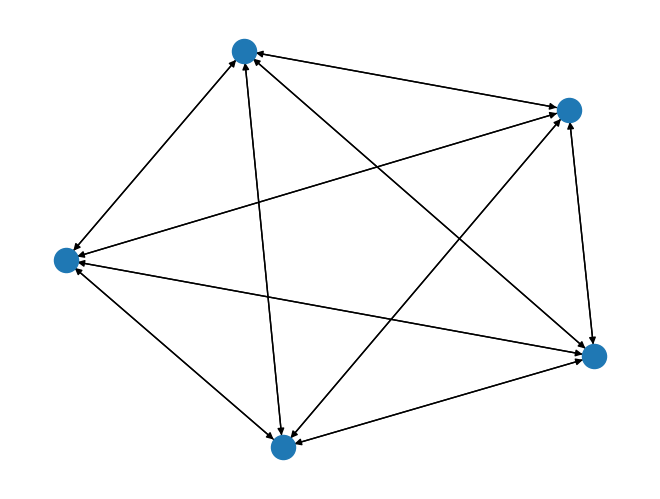

In [65]:

# create a Coupled Boolean Network with the parameters
o_cbn = CBN.generate_cbn(n_local_networks=n_local_networks,
                         n_var_network=n_var_network,
                         v_topology=v_topology,
                         n_output_variables=n_output_variables,
                         n_clauses_function=n_clauses_function)
# generate a graph of the network
o_cbn.generate_graph()

In [66]:
# Find attractors
o_cbn.find_attractors()


Find Attractors using optimized method
-------------------------
Begin of the initial loop
BEGIN TO FIND ATTRACTORS
NETWORK NUMBER : 1 PERMUTATION SIGNAL COUPLING: 0000
The expression cannot be satisfied
END OF FIND ATTRACTORS
BEGIN TO FIND ATTRACTORS
NETWORK NUMBER : 1 PERMUTATION SIGNAL COUPLING: 0001
The expression cannot be satisfied
END OF FIND ATTRACTORS
BEGIN TO FIND ATTRACTORS
NETWORK NUMBER : 1 PERMUTATION SIGNAL COUPLING: 0010
The expression cannot be satisfied
END OF FIND ATTRACTORS
BEGIN TO FIND ATTRACTORS
NETWORK NUMBER : 1 PERMUTATION SIGNAL COUPLING: 0011
The expression cannot be satisfied
END OF FIND ATTRACTORS
BEGIN TO FIND ATTRACTORS
NETWORK NUMBER : 1 PERMUTATION SIGNAL COUPLING: 0100
The expression cannot be satisfied
END OF FIND ATTRACTORS
BEGIN TO FIND ATTRACTORS
NETWORK NUMBER : 1 PERMUTATION SIGNAL COUPLING: 0101
The expression cannot be satisfied
END OF FIND ATTRACTORS
BEGIN TO FIND ATTRACTORS
NETWORK NUMBER : 1 PERMUTATION SIGNAL COUPLING: 0110
The expression 

In [67]:
# show attractors
o_cbn.show_attractors()

Network: 1
--------------
Scene: ('0', '0', '0', '0')
Attractors number: 1
--------------
['0', '0', '0', '0', '0', '0', '0', '0', '0']
--------------
Scene: ('0', '0', '0', '1')
Attractors number: 1
--------------
['0', '0', '0', '0', '0', '0', '0', '0', '1']
--------------
Scene: ('0', '0', '1', '0')
Attractors number: 2
--------------
['0', '0', '0', '0', '0', '0', '0', '1', '0']
--------------
['1', '0', '1', '0', '0', '0', '0', '1', '0']
--------------
Scene: ('0', '0', '1', '1')
Attractors number: 2
--------------
['0', '0', '0', '0', '0', '0', '0', '1', '1']
--------------
['1', '1', '1', '0', '0', '0', '0', '1', '1']
--------------
Scene: ('0', '1', '0', '0')
Attractors number: 2
--------------
['1', '0', '0', '0', '1', '0', '1', '0', '0']
--------------
['0', '0', '0', '0', '1', '0', '1', '0', '0']
--------------
Scene: ('0', '1', '0', '1')
Attractors number: 2
--------------
['0', '0', '0', '0', '1', '0', '1', '0', '1']
--------------
['1', '0', '0', '0', '1', '0', '1', '0', 

In [68]:
# Find attractors fields
# o_cbn.find_attractor_fields()

# Show attractor fields
# o_cbn.show_attractors_fields()
